In [ ]:
import os
import json
import numpy as np # Linear algebra
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For visualization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold # For evaluation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report # For evaluation
from scipy.ndimage import rotate, shift, zoom # For data augmentation
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import FileLink # For downloading the output file

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [ ]:
#Loading the datasets into dataframes
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
submission_df = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [ ]:
# Converting the train and test dataframes into numpy arrays
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
X_test = test_df.values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (42000, 784)
y_train shape: (42000,)
X_test shape: (28000, 784)


Label: 9


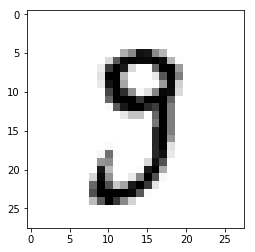

In [ ]:
# Visualizing a digit from the training data as a 28 X 28 image
some_digit = X_train[40]

some_digit_image = some_digit.reshape(28, 28)
print(f"Label: {y_train[40]}")
plt.imshow(some_digit_image, cmap="binary")
plt.show()

### Data Augmentation

In [ ]:
def shift_in_one_direction(image, direction):
    """
    Shifts an image by one pixel in the specified direction
    """
    if direction == "DOWN":
        image = shift(image, [1, 0])
    elif direction == "UP":
        image = shift(image, [-1, 0])
    elif direction == "LEFT":
        image = shift(image, [0, -1])
    else:
        image = shift(image, [0, 1])

    return image


def shift_in_all_directions(image):
    """
    Shifts an image in all the directions by one pixel
    """
    reshaped_image = image.reshape(28, 28)

    down_shifted_image = shift_in_one_direction(reshaped_image, "DOWN")
    up_shifted_image = shift_in_one_direction(reshaped_image, "UP")
    left_shifted_image = shift_in_one_direction(reshaped_image, "LEFT")
    right_shifted_image = shift_in_one_direction(reshaped_image, "RIGHT")

    return (down_shifted_image, up_shifted_image,
            left_shifted_image, right_shifted_image)


def rotate_in_all_directions(image, angle):
    """
    Rotates an image clockwise and anti-clockwise
    """
    reshaped_image = image.reshape(28, 28)
    
    rotated_images = (rotate(reshaped_image, angle, reshape=False),
                      rotate(reshaped_image, -angle, reshape=False))
    
    return rotated_images


def clipped_zoom(image, zoom_ranges):
    """
    Clips and zooms an image at the specified zooming ranges
    """
    reshaped_image = image.reshape(28, 28)
    
    h, w = reshaped_image.shape
    
    zoomed_images = []
    for zoom_range in zoom_ranges:
        zh = int(np.round(h / zoom_range))
        zw = int(np.round(w / zoom_range))
        top = (h - zh) // 2
        left = (w - zw) // 2
        
        zoomed_images.append(zoom(reshaped_image[top:top+zh, left:left+zw],
                                  zoom_range))
    
    return zoomed_images

def alter_image(image):
    """
    Alters an image by shifting, rotating, and zooming it
    """
    shifted_images = shift_in_all_directions(image)
    rotated_images = rotate_in_all_directions(image, 10)
    zoomed_images = clipped_zoom(image, [1.1, 1.2])
            
    return np.r_[shifted_images, rotated_images, zoomed_images]

X_train_add = np.apply_along_axis(alter_image, 1, X_train).reshape(-1, 784)
y_train_add = np.repeat(y_train, 8)

print(f"X_train_add shape: {X_train_add.shape}")
print(f"y_train_add shape: {y_train_add.shape}")

X_train_add shape: (336000, 784)
y_train_add shape: (336000,)


Combining the original images and the synthesized images to form a new dataset

In [ ]:
# Combining the original images and the synthesized images
X_train_combined = np.r_[X_train, X_train_add]
y_train_combined = np.r_[y_train, y_train_add]

del X_train
del X_train_add
del y_train
del y_train_add

print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")

X_train_combined shape: (378000, 784)
y_train_combined shape: (378000,)


### Modelling

In [ ]:
class ImageReshaper(BaseEstimator, TransformerMixin):
    """
    Reshapes the data to the shape required by the KerasClassifier
    """
    def __init__(self, shape):
        self.shape = shape
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.reshape(self.shape)

In [ ]:
# Function to build a model based on LeNet-5 architecture

def build_lenet5_model():
    """
    Builds and returns the model based on LeNet-5 architecture
    """
    model = Sequential()
    # Adding layers to the model
    model.add(Conv2D(6, kernel_size=5, activation='relu',
                     input_shape=(28,28,1)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(16, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    
    model.add(Dense(400, activation='relu'))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Specifying the loss function and optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Function to build a model based on a modified LeNet-5 architecture from the above mentioned notebook

def build_custom_lenet5_model():
    """
    Builds and returns the model based on a modified LeNet-5 architecture
    """
    model = Sequential()
    # Adding layers to the model
    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    # Specifying the loss function and optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [ ]:
stratified_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, indices in enumerate(stratified_fold.split(X_train_combined, y_train_combined)):
    # Creating datasets for training and testing the model 
    X_train_, y_train_ = X_train_combined[indices[0]], y_train_combined[indices[0]]
    X_test_, y_test_ = X_train_combined[indices[1]], y_train_combined[indices[1]]
    
    model_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('image_reshaper', ImageReshaper(shape=(-1, 28, 28, 1))),
        ('model', KerasClassifier(build_lenet5_model, epochs=5, batch_size=32))
    ])
    
    model_pipeline.fit(X_train_, y_train_)
    predictions = model_pipeline.predict(X_test_)
    
    print(f"Classification report for Fold {fold + 1}:")
    print(classification_report(y_test_, predictions, digits=3), end="\n\n")
    
    print(f"Confusion Matrix for Fold {fold + 1}:")
    print(confusion_matrix(y_test_, predictions), end="\n\n")
    
    del X_train_
    del X_test_
    del y_train_
    del y_test_

Epoch 1/5
302400/302400 [==============================] - 49s 160us/step - loss: 0.0782 - accuracy: 0.9753
Epoch 2/5
302400/302400 [==============================] - 44s 147us/step - loss: 0.0262 - accuracy: 0.9917
Epoch 3/5
302400/302400 [==============================] - 44s 145us/step - loss: 0.0187 - accuracy: 0.9942
Epoch 4/5
302400/302400 [==============================] - 45s 149us/step - loss: 0.0147 - accuracy: 0.9955
Epoch 5/5
302400/302400 [==============================] - 45s 149us/step - loss: 0.0123 - accuracy: 0.9960
Classification report for Fold 1:
              precision    recall  f1-score   support

           0      0.997     0.997     0.997      7437
           1      0.998     0.993     0.996      8432
           2      0.990     0.997     0.994      7519
           3      0.993     0.997     0.995      7831
           4      0.994     0.991     0.993      7330
           5      0.990     0.997     0.994      6831
           6      0.996     0.996     0.996    

In [ ]:
lenet5_model = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('image_reshaper', ImageReshaper(shape=(-1, 28, 28, 1))),
    ('model', KerasClassifier(build_lenet5_model, epochs=5, batch_size=32))
])

custom_lenet5_model = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('image_reshaper', ImageReshaper(shape=(-1, 28, 28, 1))),
    ('model', KerasClassifier(build_custom_lenet5_model, epochs=20, batch_size=32))
])


lenet5_model.fit(X_train_combined, y_train_combined)
# Getting the estimated probabilities for each class
lenet5_model_predictions = lenet5_model.predict_proba(X_test)

custom_lenet5_model.fit(X_train_combined, y_train_combined)
# Getting the estimated probabilities for each class
custom_lenet5_model_predictions = custom_lenet5_model.predict_proba(X_test)

Epoch 1/5
378000/378000 [==============================] - 57s 151us/step - loss: 0.0760 - accuracy: 0.9760
Epoch 2/5
378000/378000 [==============================] - 57s 150us/step - loss: 0.0257 - accuracy: 0.9918
Epoch 3/5
378000/378000 [==============================] - 57s 150us/step - loss: 0.0181 - accuracy: 0.9942
Epoch 4/5
378000/378000 [==============================] - 56s 149us/step - loss: 0.0143 - accuracy: 0.9955
Epoch 5/5
378000/378000 [==============================] - 56s 149us/step - loss: 0.0123 - accuracy: 0.9962
Epoch 1/20
378000/378000 [==============================] - 186s 493us/step - loss: 0.0335 - accuracy: 0.9901
Epoch 3/20
378000/378000 [==============================] - 189s 500us/step - loss: 0.0128 - accuracy: 0.9961
Epoch 8/20
378000/378000 [==============================] - 184s 488us/step - loss: 0.0058 - accuracy: 0.9981


In [ ]:
predictions = lenet5_model_predictions + custom_lenet5_model_predictions

predictions = np.argmax(predictions, axis=1)

In [ ]:
Generating the submission file
submission_df["Label"] = predictions
submission_df.to_csv('submissions.csv', index=False)


In [ ]:
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
